# Genes2Genes Alignment of fetal skin vs. organoid Fibroblast single lineage

### This runs trajectory alignment using Genes2Genes implementation available at https://github.com/Teichlab/Genes2Genes

In [ ]:
import anndata
import numpy as np
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt

import os,sys,inspect
# G2G source imports 
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import PathwayAnalyserV2
import VisualUtils
import ClusterUtils
import pickle
# Genes2Genes implementation available at: https://github.com/Teichlab/Genes2Genes

import warnings
warnings.filterwarnings("ignore")
def plotTimeSeries(al_obj, refQueryAlignerObj, plot_cells = False, plot_mean_trend= False):
        plt.subplots(1,3,figsize=(15,3))
        plt.subplot(1,3,1)
        plotTimeSeriesAlignment(al_obj) 
        plt.subplot(1,3,2)
        max_val = np.max([np.max(np.asarray(refQueryAlignerObj.ref_mat[al_obj.gene])), np.max(np.asarray(refQueryAlignerObj.query_mat[al_obj.gene]))])
        min_val = np.min([np.min(np.asarray(refQueryAlignerObj.ref_mat[al_obj.gene])), np.min(np.asarray(refQueryAlignerObj.query_mat[al_obj.gene]))])
        g = sb.scatterplot(x=refQueryAlignerObj.query_time, y=np.asarray(refQueryAlignerObj.query_mat[al_obj.gene]), alpha=0.7, color = 'midnightblue', legend=False,linewidth=0.3, s=20)  
        plt.title('Query')
        plt.ylim([min_val-0.5,max_val+0.5])
        plt.subplot(1,3,3)
        g = sb.scatterplot(x=refQueryAlignerObj.ref_time, y=np.asarray(refQueryAlignerObj.ref_mat[al_obj.gene]), color = 'forestgreen', alpha=0.7, legend=False,linewidth=0.3,s=20 ) 
        plt.title('Reference')
        plt.ylim([min_val-0.5,max_val+0.5])
        
def plotTimeSeriesAlignment(al_obj):  
        sb.scatterplot(x=al_obj.S.X, y=al_obj.S.Y, color = 'forestgreen' ,alpha=0.05, legend=False)#, label='Ref') 
        sb.scatterplot(x=al_obj.T.X, y=al_obj.T.Y, color = 'midnightblue' ,alpha=0.05, legend=False)#, label ='Query') 
        al_obj.plot_mean_trends() 
        plt.title(al_obj.gene)
        plt.xlabel('pseudotime')
        plt.ylabel('Gene expression')
        plt.axis('off')
        
        for i in range(al_obj.matched_region_DE_info.shape[0]):
            S_timebin = int(al_obj.matched_region_DE_info.iloc[i]['ref_bin'])
            T_timebin = int(al_obj.matched_region_DE_info.iloc[i]['query_bin']) 
            x_vals = [al_obj.matched_region_DE_info.iloc[i]['ref_pseudotime'],al_obj.matched_region_DE_info.iloc[i]['query_pseudotime']] 
            y_vals = [al_obj.S.mean_trend[S_timebin ], al_obj.T.mean_trend[T_timebin]] 
            plt.plot(x_vals, y_vals, color='black', linestyle='dashed', linewidth=0.6)

In [5]:
import platform
print(platform.python_version())

3.9.16


In [2]:
# ONE TIME RUN ---- retrieving and storing cellrank palantir pseudotime estimates / latent_time
if(False):
    adata_query = anndata.read_h5ad('Dinithi_scvelo_fibro_organoid_final_palantir_pseudotime.h5ad') 
    adata_ref = anndata.read_h5ad('Dinithi_scvelo_fibro_final_palantir_pseudotime.h5ad')
    adata_ref = adata_ref[ [x in ['HOXC5+ early fibroblast', 'Pre-dermal condensate','Dermal condensate','Dermal papilla' ] for x in adata_ref.obs.joint_annotation_20220202]]

    d_ref = pd.DataFrame([list(adata_ref.obs_names), 
                          list(adata_ref.obs.latent_time), 
                          list(adata_ref.obs.VelocityPalantir_matrix_pseudotime)]).transpose() 
    d_ref.columns = ['obs_name','latent_time','VelocityPalantir_matrix_pseudotime']
    d_query = pd.DataFrame([list(adata_query.obs_names), 
                          list(adata_query.obs.latent_time), 
                          list(adata_query.obs.VelocityPalantir_matrix_pseudotime)]).transpose() 
    d_query.columns = ['obs_name','latent_time','VelocityPalantir_matrix_pseudotime']
    d_ref.to_csv('ref_fibro_final_cellrank_based_pseudotime.csv')
    d_query.to_csv('organoid_fibro_final_cellrank_based_pseudotime.csv')

In [4]:
input_dir = '../[Collab]Haniffa_Fetal_Skin/org_output/'
adata_ref = anndata.read_h5ad(input_dir + 'adata_ref_fib_gplvm_pseudotime.h5ad')
adata_query = anndata.read_h5ad(input_dir +'adata_org_fib_gplvm_pseudotime.h5ad') 

In [6]:
# retrieving cellrank based pseudotime estimates of the cells 
d_ref = pd.read_csv('ref_fibro_final_cellrank_based_pseudotime.csv', index_col='obs_name')
d_query = pd.read_csv('organoid_fibro_final_cellrank_based_pseudotime.csv', index_col='obs_name')
adata_ref.obs['time'] = list(d_ref.loc[adata_ref.obs_names]['latent_time'])
adata_query.obs['time'] = list(d_query.loc[adata_query.obs_names]['latent_time'])

In [10]:
import scanpy as sc
sc.pp.normalize_per_cell(adata_ref, 10000) 
sc.pp.log1p(adata_ref)
sc.pp.normalize_per_cell(adata_query, 10000) 
sc.pp.log1p(adata_query)

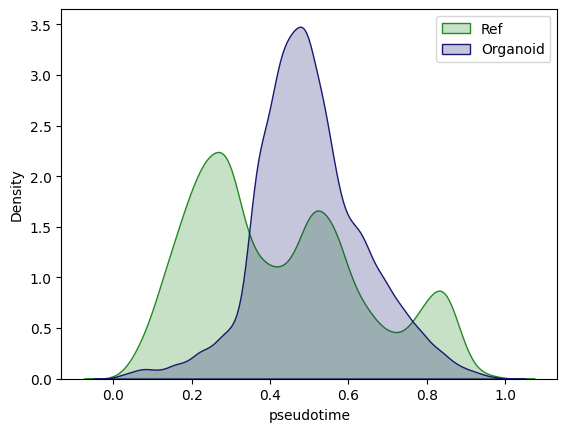

In [13]:
# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='Ref', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='Organoid', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.show()

In [14]:
temp = adata_query
def average_pseudotime(adata, time_var, anno_var):
    df = pd.DataFrame([adata.obs[time_var], adata.obs[anno_var]] ).transpose().groupby(anno_var).mean()
   ## df['palantir_pseudotime'] = np.round(df[time_var], decimals=2)
    return df
df = average_pseudotime(temp, 'time', 'ANNOTATION')
df.sort_values('time')
temp = adata_ref
df = average_pseudotime(temp, 'time', 'ANNOTATION')
df.sort_values('time')

,time
ANNOTATION,
HOXC5+ early fibroblast,0.215419
Pre-dermal condensate,0.429043
Dermal condensate,0.584788
Dermal papilla,0.816441


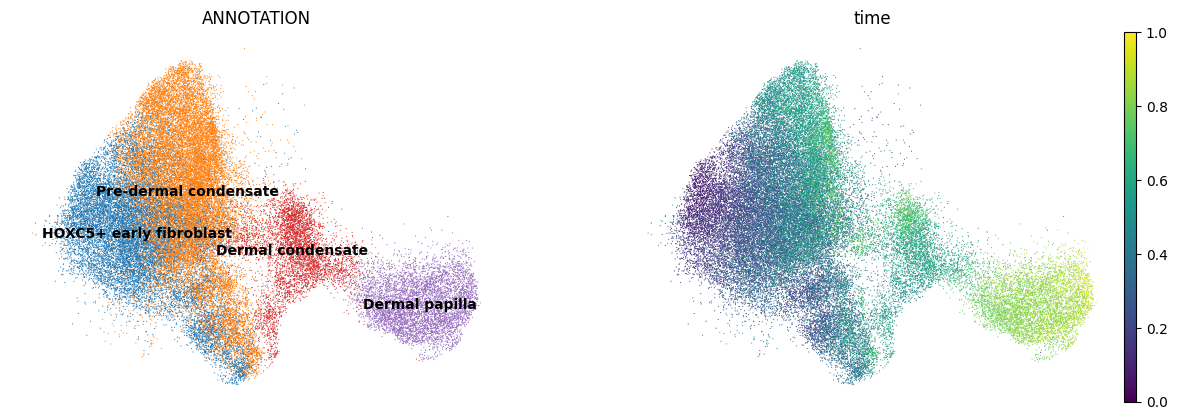

In [17]:
# integrated scVI embedding of ref 
sc.pl.umap(adata_ref, color = ['ANNOTATION','time'], legend_loc='on data', frameon=False)

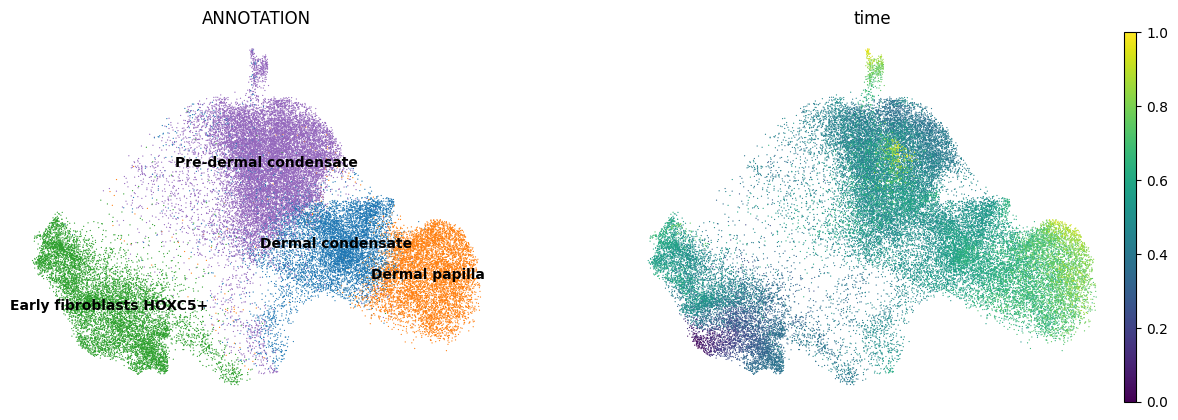

In [16]:
# integrated scVI embedding of organoid
sc.pl.umap(adata_query, color = ['ANNOTATION','time'], legend_loc='on data', frameon=False)

In [78]:
print(adata_ref.shape)
print(adata_query.shape)

(48490, 28885)
(38825, 36601)


In [18]:
print(min(adata_ref.obs['time']), max(adata_ref.obs['time'])) 
print(min(adata_query.obs['time']), max(adata_query.obs['time']))

0.0 1.0
0.0 1.0


In [19]:
import colorcet as cc
from optbinning import ContinuousOptimalBinning
from scipy.stats import gaussian_kde

class VisualUtils():
    
    def __init__(self, adata_ref, adata_query, cell_type_colname, S_len, T_len, titleS = 'Reference', titleT = 'Query', mode='comp', write_file=False, optimal_binning=True, PLOT=True):
        self.write_file = write_file 
        if(mode=='comp'):
            self.titleS = titleS
            self.titleT = titleT
            
            n_points = S_len
            while(True):
              #  print('iteration')
                # later to replace with a better optimal binning that gives exact number we request
              #  print('# trying max n points for optimal binning =', n_points)
                adata_ref, bm1 = self.pseudotime2bin_celltypes(adata_ref, n_points, optimal_binning=optimal_binning)
                adata_query, bm2 = self.pseudotime2bin_celltypes(adata_query, n_points, optimal_binning=optimal_binning)
    
                if(not (len(bm1) == len(bm2))):
                    n_points=n_points-1               
                    if(n_points<=5):
                        print('Consider equal length binning')
                        break
                else:
                    print('====================================================')
                    print('Optimal equal number of bins for R and Q = ',len(bm1))
                    break
                  
            if(PLOT):
                plt.subplots(1,2, figsize=(10,3))
                x = list(adata_ref.obs.time)
                plt.subplot(1,2,1)
                sb.kdeplot(list(adata_ref.obs.time), color='ForestGreen' , fill=True)
                for s in bm1: 
                    plt.axvline(x=s, color='ForestGreen')
                x = list(adata_query.obs.time)
                plt.subplot(1,2,2)
                sb.kdeplot(list(adata_query.obs.time),color='midnightblue', fill=True)
                for s in bm2: 
                    plt.axvline(x=s, color='midnightblue')
                
            meta1 = self.plot_cell_type_proportions(adata_ref, cell_type_colname, 'bin_ids',None,'tab20')
            meta2 = self.plot_cell_type_proportions(adata_query, cell_type_colname, 'bin_ids',None,'tab20')
            if(not optimal_binning):
                meta1 = self.simple_interpolate(meta1,S_len)
                meta2 = self.simple_interpolate(meta2,T_len)
          #  meta1.loc[1] = meta1.loc[0] + meta1.loc[1]
          #  meta2.loc[1] = meta2.loc[0] + meta2.loc[1]
          #  meta1.loc[0] = np.repeat(0.0,len(np.unique(adata_ref.obs[cell_type_colname])) )
          #  meta2.loc[0] = np.repeat(0.0,len(np.unique(adata_query.obs[cell_type_colname])))
            
            temp1 = pd.Series(np.repeat(0.0,len(np.unique(adata_ref.obs[cell_type_colname])) ))
            temp1.index = meta1.columns
            meta1 = pd.concat([pd.DataFrame(temp1).transpose(),meta1.loc[:]]).reset_index(drop=True)
            
            temp2 = pd.Series(np.repeat(0.0,len(np.unique(adata_query.obs[cell_type_colname])) ))
            temp2.index = meta2.columns
            meta2 = pd.concat([pd.DataFrame(temp2).transpose(),meta2.loc[:]]).reset_index(drop=True)
            
            self.metaS = meta1
            self.metaT = meta2
            
            self.optimal_bining_S = bm1
            self.optimal_bining_T = bm2
         

    def get_optimal_binning(self, time_var_arr, n_points):
        x = time_var_arr
        optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical", max_n_bins=n_points)
        # this pacakge uses mixed integer programming based optimization to determine an optimal binning
        #print('kde estimate start')
        #kde = gaussian_kde(x)
        #density_values = kde(x)
        #print('kde estimate end')
        
        #optb.fit(x, density_values)
        optb.fit(x, x)
        #sb.kdeplot(x, fill=True)
        #for s in optb.splits: 
        #    plt.axvline(x=s)
        #print(len(optb.splits))
        return optb.splits


    # annotates cells with their respective bins based on interpolated pseudotime points
    def pseudotime2bin_celltypes(self, adata, n_points, optimal_binning = True):
        
          #  print('pseudotimebinning started')

            adata.obs['bin_ids'] = np.repeat(-1,adata.shape[0])
            if(optimal_binning):
                bin_margins = self.get_optimal_binning(np.asarray(adata.obs.time) , n_points)
            else:
                bin_margins =  np.linspace(0,1,n_points+1)
            #print('computed the margins for ' + str(len(bin_margins)) +  ' bins')
            #print(bin_margins)
            bin_ids = []
            k = 0 
            #print('bin margins', bin_margins)
            for i in range(len(bin_margins)):
                if(i==0):
                    logic = np.logical_and(adata.obs.time >= 0, adata.obs.time < bin_margins[i+1])
                    #print('i==0', adata[logic].shape[0])
                elif(i==len(bin_margins)-1):
                    logic =  np.logical_and(adata.obs.time >= bin_margins[i], adata.obs.time <= 1.0)
                else:
                    logic =  np.logical_and(adata.obs.time >= bin_margins[i], adata.obs.time < bin_margins[i+1])
                adata.obs['bin_ids'][logic] = i 
                
           # print('pseudotimebinning ended')
            return adata, bin_margins

    # for plotting or getting celltype freq counts per bin
    def plot_cell_type_proportions(self, adata, cell_type_colname, covariate_colname, sorter, color_scheme_name="Spectral", plot=False):
        meta = pd.DataFrame(np.vstack((adata.obs[cell_type_colname],adata.obs[covariate_colname])).transpose(),columns=[cell_type_colname,covariate_colname])
        
        meta['COUNTER'] = 1
        meta = meta.groupby([covariate_colname,cell_type_colname])['COUNTER'].sum().unstack()
        meta = meta.fillna(0)
        #meta = meta.transpose()
        #meta = meta.sort_values(by=covariate_colname, key=sorter)
        if(plot):
            p = meta.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True, color=sb.color_palette(color_scheme_name, 20), grid = False)
            #p.legend(labels = ['not infected','infected'], loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
            p.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
        return meta
    
    
    def simple_interpolate(self,meta, n_points):
        for i in range(n_points):
            #print(k)
            if(i not in meta.index):
                k=i
                while(k not in meta.index):
                    k = k-1
                _temp = meta.loc[k].copy()
                _temp.name = i
                meta = meta.append(_temp)
        meta = meta.sort_index()
        return meta
    
    
    def get_celltype_composition_across_time(adata_ref, adata_query, n_points, ANNOTATION_COLNAME, optimal_binning=True
                                        , order_S_legend=None, order_T_legend=None, PLOT=True):
        
        a = sb.color_palette(cc.glasbey_hv, n_colors=3)
        vega_20 = [
            '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728',
            '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2',
            '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
        ]
        
        vega_20 = [ "#7C87B9", "#BFC1D4","#BB7784","#EAD3C7" ]
        
        order_S_legend = [2,3,0,1]
        order_T_legend = [2,3,0,1]
        
        vs = VisualUtils(adata_ref, adata_query, cell_type_colname = ANNOTATION_COLNAME, 
                        S_len=n_points, T_len=n_points, titleS='Reference', titleT='Query',
                        write_file=False, optimal_binning=optimal_binning, PLOT=PLOT)
        
        if(PLOT):
        
            #ax = vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=vega_20, grid = False, legend=True, width=0.7,align='edge',figsize=(10,3))
            ax = vs.metaS.apply(lambda x: x, axis=1).plot(kind='bar',stacked=True,color=vega_20, grid = False, legend=True, width=0.7,align='edge',figsize=(10,3))
            ax.legend(bbox_to_anchor=(1.1, 1.44))
            plt.savefig('legend.pdf', bbox_inches='tight')
            if(order_S_legend is not None):
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles=[handles[idx] for idx in order_S_legend],labels=[labels[idx] for idx in order_S_legend],bbox_to_anchor=(1.0, 1.0))

            #ax = vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=vega_20, grid = False, legend=True, width=0.7,align='edge',figsize=(10,3))
            ax = vs.metaT.apply(lambda x: x, axis=1).plot(kind='bar',stacked=True,color=vega_20, grid = False, legend=True, width=0.7,align='edge',figsize=(10,3))
            ax.legend(bbox_to_anchor=(1.1, 1.05))
            if(order_T_legend is not None):
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles=[handles[idx] for idx in order_T_legend],labels=[labels[idx] for idx in order_T_legend],bbox_to_anchor=(1.0, 1.0))
            vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=vega_20, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
            plt.axis('off')
            plt.savefig('fetalskin_timebins.pdf')
            vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=vega_20, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
            plt.axis('off')
            plt.savefig('organoid_timebins.pdf')

        return vs 
    
    
    def visualize_gene_alignment(self, al_obj):

        fig = plt.figure(figsize=(4,3))
        heights = [1, 3, 1] 
        gs = plt.GridSpec(3, 1, height_ratios=heights)
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[1, 0],sharex=ax1)
        ax3 = fig.add_subplot(gs[2, 0],sharex=ax1)

        #plt.subplots(3,1, gridspec_kw={'height_ratios': [1,10]})
        plt.subplot(3,1,1)
        self.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=vega_20, grid = False, legend=False, width=0.7, ax=ax1)
        self.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=vega_20, grid = False, legend=False, width=0.7,ax=ax3)
        plt.subplot(3,1,2)
        for i in range(al_obj.matched_region_DE_info.shape[0]):
                    S_timebin = int(al_obj.matched_region_DE_info.iloc[i]['ref_bin'])
                    T_timebin = int(al_obj.matched_region_DE_info.iloc[i]['query_bin'])
                    #print(S_timebin, T_timebin)
                    x_vals = [al_obj.matched_region_DE_info.iloc[i]['query_pseudotime'],al_obj.matched_region_DE_info.iloc[i]['ref_pseudotime']]
                    x_vals = [T_timebin+1, S_timebin+1]
                    y_vals = [0,1]
                    plt.plot(x_vals, y_vals, marker='.', color='black', linewidth=0.5)
        #ax2.set_xlim([0,14])

        def set_grid_off(ax):
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.figure.tight_layout()
            ax.grid(False)

        set_grid_off(ax1); set_grid_off(ax2); set_grid_off(ax3); 
        ax1.set_ylabel('Reference')
        ax3.set_ylabel('Query')
        fig.text(0.5, -0.05, 'Pseudotime bins with cell type composition', ha='center')
        ax1.set_title('Alignment w.r.t cell type compositions')


Optimal equal number of bins for R and Q =  13


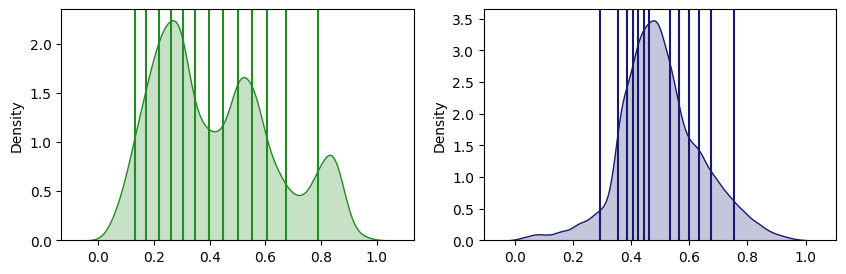

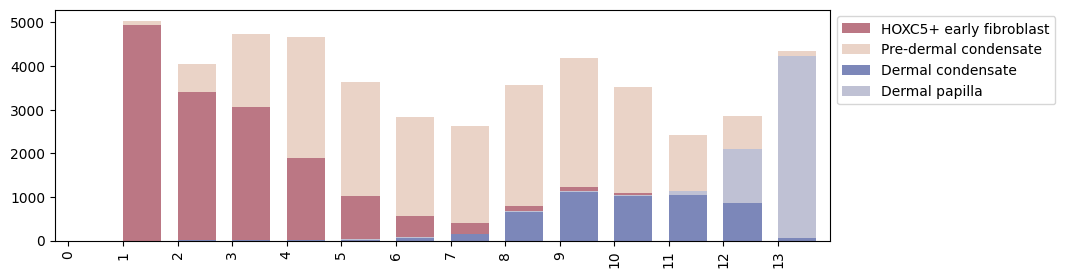

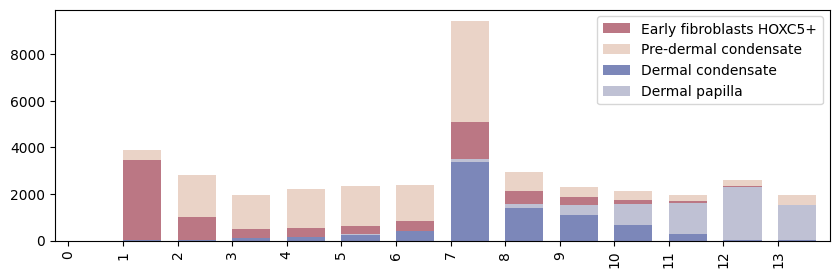

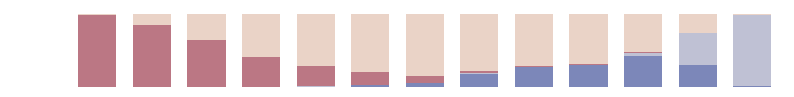

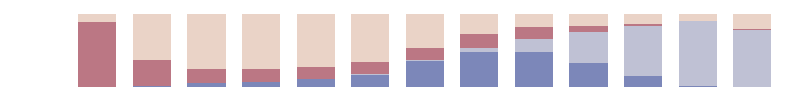

In [20]:
import matplotlib as mpl
mpl.rcParams["pdf.fonttype"] = 42

vs = VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=40, 
                                     ANNOTATION_COLNAME='ANNOTATION', optimal_binning=True)

In [21]:
common_genes = np.intersect1d(adata_ref.var_names, adata_query.var_names)
len(common_genes)

20011

In [24]:
def get_human_TF_list(): 
    # get a human TF list 
    TF_list = pd.read_csv('huamn_TF_list.csv',skiprows=1)
    np.unique(TF_list['Unnamed: 3'], return_counts=True) # There are only 1639 true TFs out of 2765 TFs in this list 
    TF_list = TF_list[TF_list['Unnamed: 3']=='Yes']
    TF_list['Name']
    return TF_list
human_TFs = get_human_TF_list()
human_TFs = np.intersect1d(common_genes , np.asarray(human_TFs['Name']) )

In [26]:
len(human_TFs)

1584

In [27]:
gene_list = np.intersect1d(human_TFs, common_genes)

In [28]:
len(gene_list)

1584

In [29]:
def filter_unreliable_genes_in_alignment(MAX_nCELLs = 10):
    genes2retain = []
    for g in aligner.gene_list:
        r_cell_count = np.unique(aligner.ref_mat[g]>0, return_counts=True)
        q_cell_count = np.unique(aligner.query_mat[g]>0, return_counts=True)

        nPosR = (aligner.ref_mat[g] > 0).sum()
        nPosQ = (aligner.query_mat[g] > 0).sum()

        if(nPosR >= MAX_nCELLs and nPosQ >= MAX_nCELLs) :
            genes2retain.append(g)
        elif(nPosR >= MAX_nCELLs and nPosQ==0):
            genes2retain.append(g)
        elif(nPosR == 0 and nPosQ >= MAX_nCELLs):
            genes2retain.append(g)
        else:
            continue 
            
    return genes2retain 
aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, len(vs.optimal_bining_S))
genes2retain = filter_unreliable_genes_in_alignment()

already_ran_aliger = False
if(already_ran_aliger):
    # remove alignments from already computed aligner 
    alignments2retain = []
    for i in range(len(aligner.gene_list)):
        if(aligner.results[i].gene in genes2retain):
            alignments2retain.append(aligner.results[i])
    aligner.results = alignments2retain
    genes2discard = np.setdiff1d(aligner.gene_list, genes2retain) 
    for g in genes2discard:
        del aligner.results_map[g]
    aligner.gene_list = genes2retain

In [30]:
len(genes2retain)

1363

In [31]:
gene_list = genes2retain # np.setdiff1d( genes2retain, np.intersect1d(human_TFs, common_genes)) 

In [ ]:
aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, len(vs.optimal_bining_S))
aligner.WEIGHT_BY_CELL_DENSITY = True
aligner.WINDOW_SIZE=0.1
aligner.state_params = [0.99,0.1,0.7]
aligner.optimal_binning = True
aligner.opt_binning_S = vs.optimal_bining_S
aligner.opt_binning_T = vs.optimal_bining_T
aligner.align_all_pairs()

In [36]:
#pickle.dump(aligner, open('../../../../GOOGLE_DRIVE_MOUNT/G2G_Analysis/SkinOrgData/g2g/aligner_12July_TF_Fibro.pkl', 'wb')) 
with open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/SkinOrgData/g2g/aligner_12July_TF_Fibro.pkl', 'rb') as f:
    aligner = pickle.load(f)


In [ ]:
for a in aligner.results:
    a.gene_pair = a.gene
#aligner.show_ordered_alignments()

In [27]:
#pickle.dump(aligner, open('../../../../GOOGLE_DRIVE_MOUNT/G2G_Analysis/SkinOrgData/g2g/aligner_12July_HVG_Fibro.pkl', 'wb')) 

Average Alignment:  MMMMMMMMMMMMM


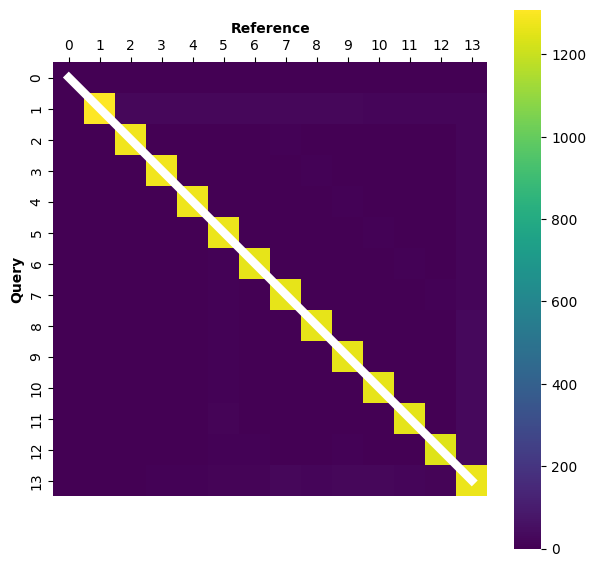

In [22]:
import VisualUtils
average_alignment, alignment_path =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_list)
mat = ClusterUtils.get_pairwise_match_count_mat(aligner,aligner.gene_list )
print('Average Alignment: ', average_alignment)

VisualUtils.plot_alignment_path_on_given_matrix(paths = [alignment_path], mat=mat)
plt.savefig('TF_average_alignment.pdf', bbox_inches='tight')

run
cluster:  0 IIIDIDIDIDIIIIIIIDDDDDDDDD 18
cluster:  1 MMMMMMDIIIIMMMWWW 16
cluster:  2 MMMMMMMMMMMMM 1289
cluster:  3 DDDMMMMMIIIMMMMM 3
cluster:  4 IIIDDDMMMMMMMMMM 6
cluster:  5 MMMMMMIIIMMMMWDD 10
cluster:  6 IIIDIDDDDMMMMMMMMI 6
cluster:  7 IIIIIIMMMIIIIDDDDDDDDDD 2
cluster:  8 MMMMMIIIIDDDMMMMD 1
cluster:  9 MIVVVVVVVVVIDIDDDDDDDDDDD 1
cluster:  10 IIIDDDDDMMMMMMMMVV 6
cluster:  11 IIIDIDIDMMMMDMIIIDDDD 1
cluster:  12 DDDDDDDMMMMMMIIIIIII 2
cluster:  13 IIMMMMMMMIIIIDDDDDD 1
cluster:  14 MMMMIIIIIMMMDDDDDM 1


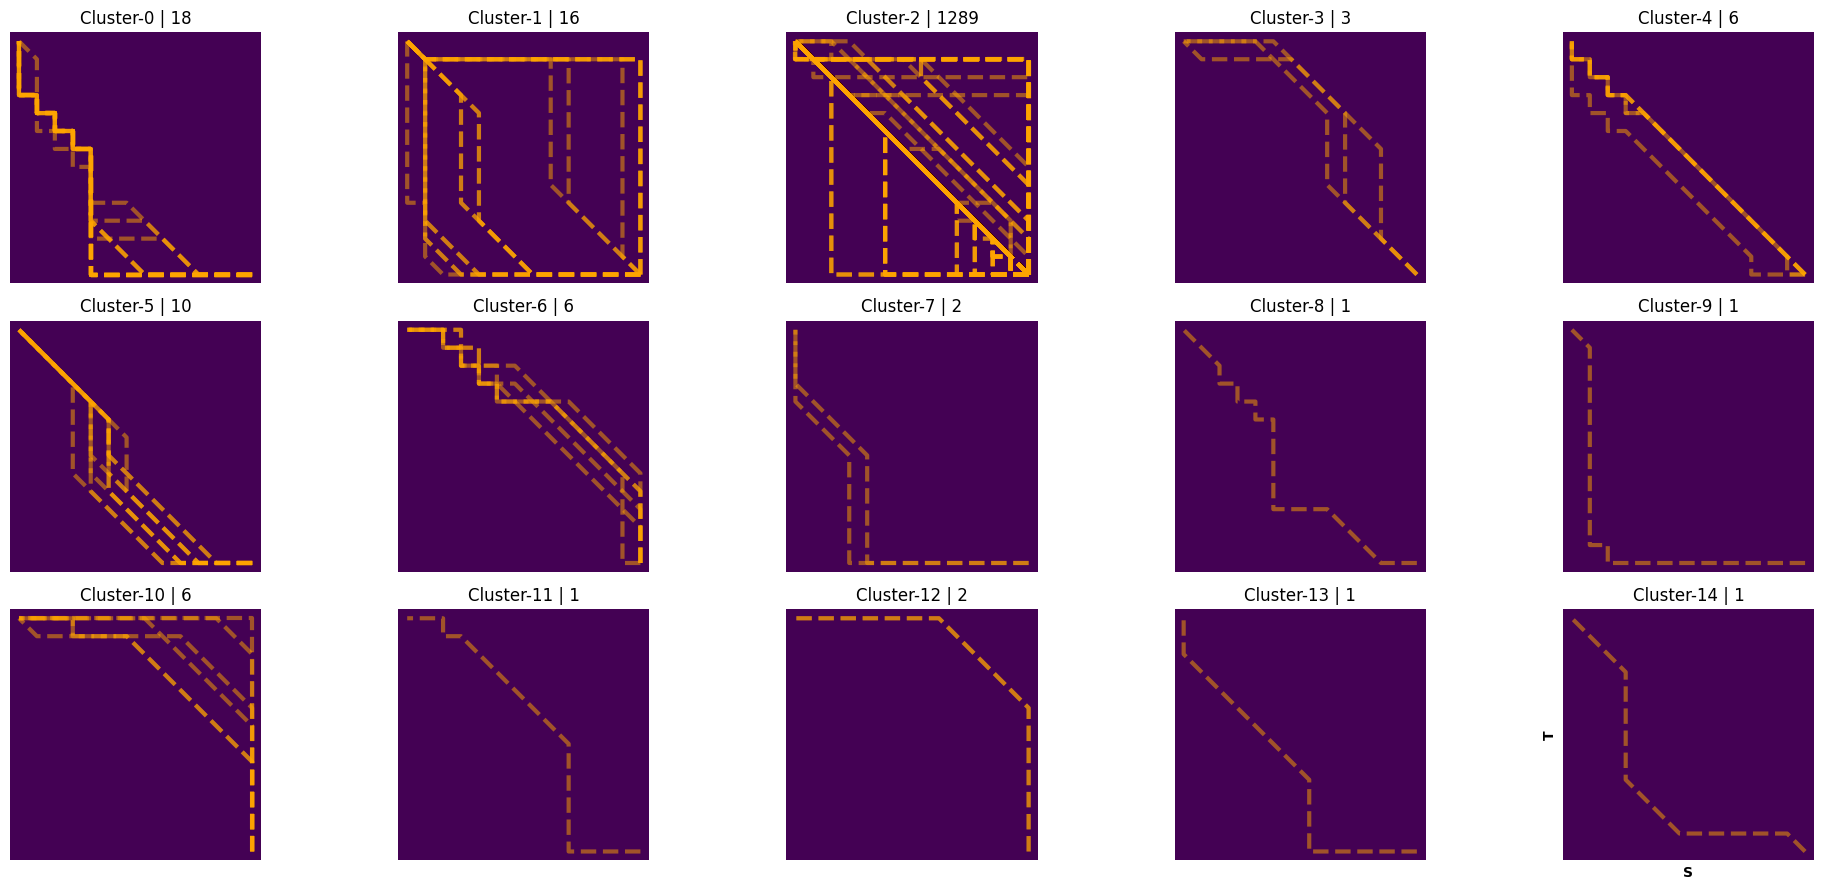

In [42]:
ClusterUtils.run_hierarchical_clustering_with_binary_encode_alignment_path_hamming(aligner, DIST_THRESHOLD=0.25)

for i in range(len(aligner.gene_clusters)):
        average_alignment, avg_path =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_clusters[i] )
        print('cluster: ', i, average_alignment, len(aligner.gene_clusters[i]))

mean matched percentage:  95.76 %
mean matched percentage wrt ref:  96.82 %
mean matched percentage wrt query:  96.42 %


Text(0.5, 0, 'Alignment Similarity Percentage')

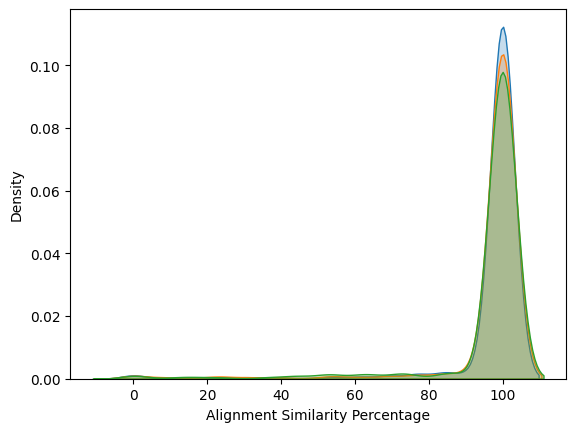

In [47]:


# The overall alignment distribution statistics
import matplotlib as mpl
mpl.style.use('default')
df = aligner.get_match_stat_for_all_genes() 
print('mean matched percentage: ', round(np.mean(df['match %']),2),'%' )
print('mean matched percentage wrt ref: ',round(np.mean(df['match % S']),2),'%'  )
print('mean matched percentage wrt query: ', round(np.mean(df['match % T']),2),'%' )
sb.kdeplot(df['match % S'], fill=True, label='match % Reference')
sb.kdeplot(df['match % T'], fill=True,label='match % Query')
sb.kdeplot(df['match %'], fill=True,label='Alignment Similarity %')
#plt.legend()
plt.xlabel('Alignment Similarity Percentage')

In [44]:
mismatched_genes = np.setdiff1d( aligner.gene_list,aligner.gene_clusters[2])
len(mismatched_genes)

74

In [10]:
genes = ['HOXC5',
'HOXB2',
'HOXB3',
'HOXB8',
'FOXO1',
'AHR',
'TRPS1',
'POU2F2',
'HOXA10',
'DLX2',
'ESRRG',
'SIX4',
'SCX',
'HOXA7',
'GFI1B',
'SALL1',
'TBPL2',
'FOXG1',
'UN28B',
'HOXC6',
'FOS',
'TBX5',
'SIZ3',
'LHX6',
'POU3F3',
'HMX1',
'DLX1']

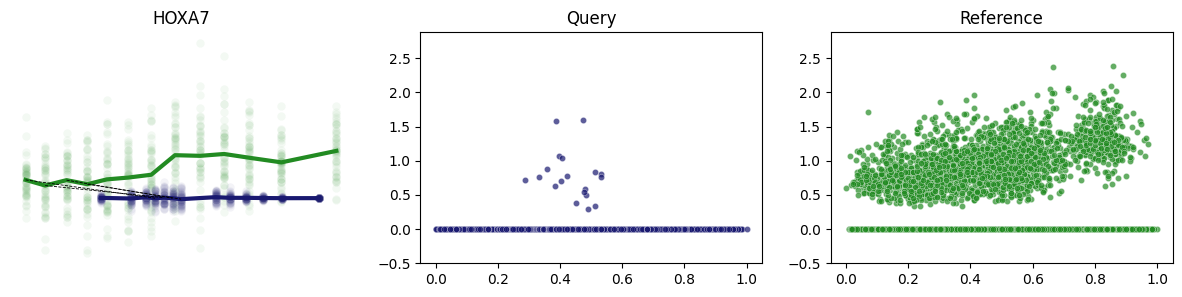

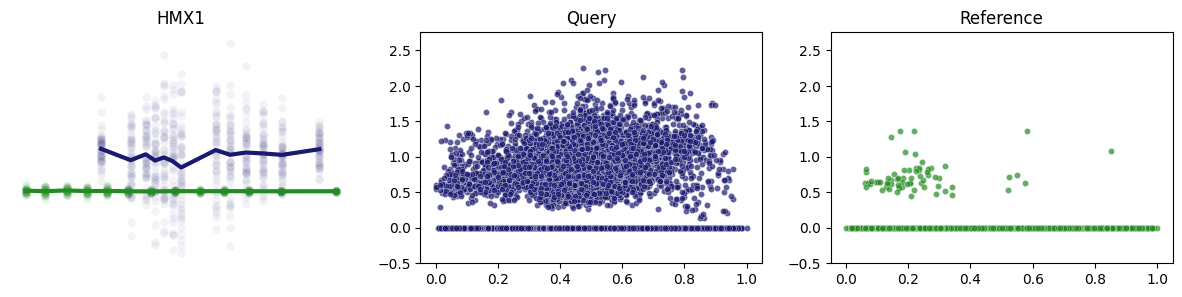

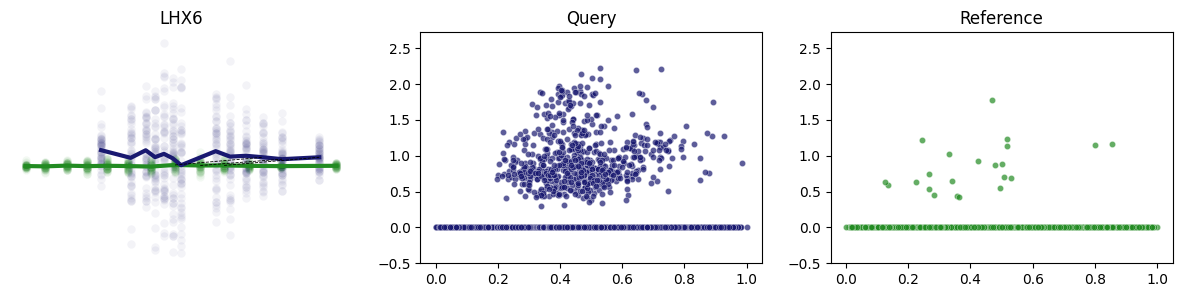

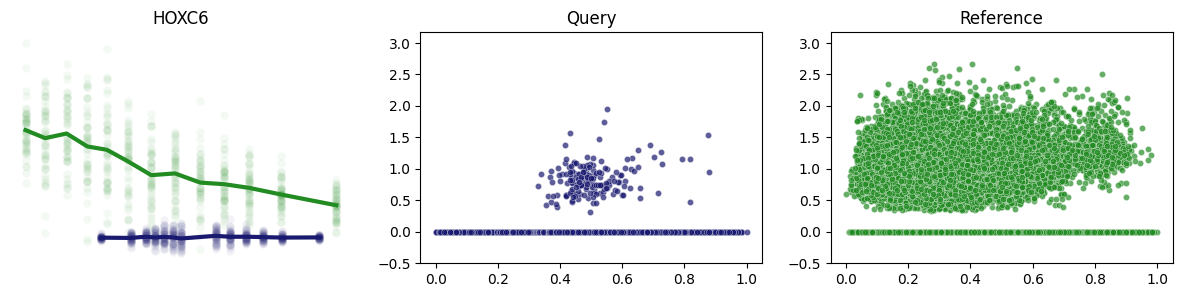

In [76]:
def plotTimeSeries(al_obj, refQueryAlignerObj, plot_cells = False, plot_mean_trend= False):
        plt.subplots(1,3,figsize=(15,3))
        plt.subplot(1,3,1)
        plotTimeSeriesAlignment(al_obj) 
        plt.subplot(1,3,2)
        max_val = np.max([np.max(np.asarray(refQueryAlignerObj.ref_mat[al_obj.gene])), np.max(np.asarray(refQueryAlignerObj.query_mat[al_obj.gene]))])
        min_val = np.min([np.min(np.asarray(refQueryAlignerObj.ref_mat[al_obj.gene])), np.min(np.asarray(refQueryAlignerObj.query_mat[al_obj.gene]))])
        g = sb.scatterplot(x=refQueryAlignerObj.query_time, y=np.asarray(refQueryAlignerObj.query_mat[al_obj.gene]), alpha=0.7, color = 'midnightblue', legend=False,linewidth=0.3, s=20)  
        plt.title('Query')
        plt.ylim([0-0.5,max_val+0.5])
        plt.subplot(1,3,3)
        g = sb.scatterplot(x=refQueryAlignerObj.ref_time, y=np.asarray(refQueryAlignerObj.ref_mat[al_obj.gene]), color = 'forestgreen', alpha=0.7, legend=False,linewidth=0.3,s=20 ) 
        plt.title('Reference')
        plt.ylim([0-0.5,max_val+0.5])
        
def plotTimeSeriesAlignment(al_obj):  
        sb.scatterplot(x=al_obj.S.X, y=al_obj.S.Y, color = 'forestgreen' ,alpha=0.05, legend=False)#, label='Ref') 
        sb.scatterplot(x=al_obj.T.X, y=al_obj.T.Y, color = 'midnightblue' ,alpha=0.05, legend=False)#, label ='Query') 
        al_obj.plot_mean_trends() 
        plt.title(al_obj.gene)
        plt.xlabel('pseudotime')
        plt.ylabel('Gene expression')
        plt.axis('off')
        
        for i in range(al_obj.matched_region_DE_info.shape[0]):
            S_timebin = int(al_obj.matched_region_DE_info.iloc[i]['ref_bin'])
            T_timebin = int(al_obj.matched_region_DE_info.iloc[i]['query_bin']) 
            x_vals = [al_obj.matched_region_DE_info.iloc[i]['ref_pseudotime'],al_obj.matched_region_DE_info.iloc[i]['query_pseudotime']] 
            y_vals = [al_obj.S.mean_trend[S_timebin ], al_obj.T.mean_trend[T_timebin]] 
            plt.plot(x_vals, y_vals, color='black', linestyle='dashed', linewidth=0.6)
            

plotTimeSeries(aligner.results_map['HOXA7'], aligner, plot_cells=True)
#plt.savefig('figs/figs/HOXA7.pdf', bbox_inches='tight')
plotTimeSeries(aligner.results_map['HMX1'], aligner, plot_cells=True)
#plt.savefig('figs/figs/HMX1.pdf', bbox_inches='tight')
plotTimeSeries(aligner.results_map['LHX6'], aligner, plot_cells=True)
#plt.savefig('figs/figs/LHX6.pdf', bbox_inches='tight')
plotTimeSeries(aligner.results_map['HOXC6'], aligner, plot_cells=True)
#plt.savefig('figs/figs/HOXC6.pdf', bbox_inches='tight')

In [48]:
x =  PathwayAnalyserV2.get_ranked_genelist(aligner)
x = pd.DataFrame(x)
l2fc = []
for gene in x.index:
    l2fc.append(np.log2(np.mean(list(aligner.ref_mat.loc[:,gene]))/np.mean(list(aligner.query_mat.loc[:,gene])) )) 
x[2] = l2fc
x.columns = ['sim','l2fc']
x['color'] = np.repeat('green',x.shape[0])
x.loc[x['sim']<=0.5,'color'] = 'red'
x['abs_l2fc'] = np.abs(x['l2fc']) 
x = x.sort_values(['sim','abs_l2fc'],ascending=[True, False])

x

,sim,l2fc,color,abs_l2fc
Gene,,,,
TBX5,0.0,8.549689,red,8.549689
HMX1,0.0,-7.113777,red,7.113777
DLX1,0.0,-6.879273,red,6.879273
HOXC6,0.0,6.485124,red,6.485124
NR2F1,0.0,-6.189519,red,6.189519
...,...,...,...,...
ZNF32,1.0,0.004653,green,0.004653
ZHX2,1.0,0.004337,green,0.004337
AEBP1,1.0,-0.002420,green,0.002420


In [51]:
for g in aligner.gene_clusters[0]:
    print(g)

BHLHE41
DLX1
FOS
FOXQ1
HMX1
HOXC6
JUND
LHX6
MEF2B
NME2
NR2F1
POU3F3
PRRX2
SCX
SIX2
TBX5
ZFPM1
ZNF804B


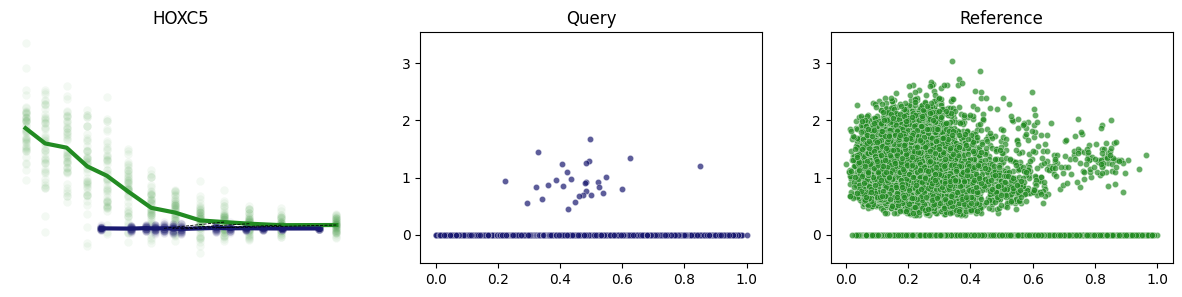

In [121]:
plotTimeSeries(aligner.results_map['HOXC5'], aligner, plot_cells=True) 
plt.savefig('HOXC5.png')

In [54]:
opt_costs = [] 
match_sims = []
for g in aligner.gene_list:
    opt_costs.append(aligner.results_map[g].fwd_DP.opt_cost) 
    match_sims.append(aligner.results_map[g].get_series_match_percentage()[0])

In [55]:
df = pd.DataFrame([aligner.gene_list, match_sims, opt_costs]).transpose() 
df = df.sort_values(by=[1,2], ascending=[True, False])
df

,0,1,2
109,DLX1,0.0,67.468115
177,FOS,0.0,67.468115
271,HMX1,0.0,67.468115
290,HOXC6,0.0,67.468115
330,JUND,0.0,67.468115
...,...,...,...
53,BHLHE22,100.0,-0.673672
45,BATF3,100.0,-0.77807
1341,ZNF99,100.0,-0.786581
507,PAX6,100.0,-0.803193


In [60]:
diff_genes = np.setdiff1d(aligner.gene_list, aligner.gene_clusters[2])

In [61]:
len(diff_genes)

74

In [64]:
def compute_mmldist(gex1,gex2):
    
        μ_S = np.mean(gex1); σ_S = np.std(gex1); 
        μ_T = np.mean(gex2); σ_T = np.std(gex2); 
        
        ref_data = gex1 
        query_data = gex2

        I_ref_model, I_refdata_g_ref_model = MyFunctions.run_dist_compute_v3(ref_data, μ_S, σ_S) 
        I_query_model, I_querydata_g_query_model = MyFunctions.run_dist_compute_v3(query_data, μ_T, σ_T) 
        I_ref_model, I_querydata_g_ref_model = MyFunctions.run_dist_compute_v3(query_data, μ_S, σ_S) 
        I_query_model, I_refdata_g_query_model = MyFunctions.run_dist_compute_v3(ref_data, μ_T, σ_T) 
        
        match_encoding_len1 = I_ref_model + I_querydata_g_ref_model + I_refdata_g_ref_model
        match_encoding_len1 = match_encoding_len1/(len(query_data)+len(ref_data))
        match_encoding_len2 = I_query_model + I_refdata_g_query_model + I_querydata_g_query_model
        match_encoding_len2 = match_encoding_len2/(len(query_data)+len(ref_data))
        match_encoding_len = (match_encoding_len1 + match_encoding_len2 )/2.0 
        
        null = (I_ref_model + I_refdata_g_ref_model + I_query_model + I_querydata_g_query_model)/(len(query_data)+len(ref_data))
        match_compression =   match_encoding_len - null 

        return round(float(match_compression.numpy()),4) 


genes = aligner.gene_list
match_costs_across_time = {}
ranked_genes = []

for t in range(0,13):
    match_costs = []
    for g in genes:
        al = aligner.results_map[g]
        Mmat = al.fwd_DP.DP_M_matrix[1:14,1:14] 
        c = compute_mmldist(al.S.data_bins[t], al.T.data_bins[t])
        match_costs.append(c)
        #match_costs.append(Mmat[t,t])
    d = pd.DataFrame( [genes, match_costs] ) .transpose() 
    d.columns = ['gene','mml_opt_cost_in_prefix_alignment']
    d['rank'] = d.sort_values('mml_opt_cost_in_prefix_alignment', ascending=False).index
    match_costs_across_time[t] = d

In [65]:
len(match_costs_across_time[0])

1363

In [66]:
gene_ordered = aligner.gene_list
mat = [] 
for t in range(0,13):
    d = match_costs_across_time[t] 
    d = d.set_index('gene')
    mat.append(list(d.loc[gene_ordered]['mml_opt_cost_in_prefix_alignment'])) 
mat = pd.DataFrame(mat).transpose()
mat.index = gene_ordered

In [67]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
t = scaler.fit_transform(mat.T)
t = pd.DataFrame(t.T)
t.index = mat.index

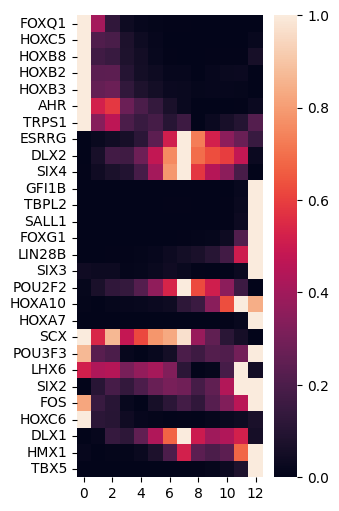

In [27]:

genes = [
'FOXQ1',
'HOXC5',
'HOXB8',
'HOXB2', 
'HOXB3', 
'AHR',   
'TRPS1', 
'ESRRG', 
'DLX2',  
'SIX4',  
'GFI1B', 
'TBPL2', 
'SALL1',  
'FOXG1', 
'LIN28B',
'SIX3',
'POU2F2',
'HOXA10',
'HOXA7',   
'SCX',   
'POU3F3',
'LHX6',  
'SIX2',  
'FOS',   
'HOXC6', 
'DLX1',
'HMX1',  
'TBX5'  
]
plt.subplots(1,1,figsize=(3,6))
c = sb.heatmap(t.loc[genes]) 


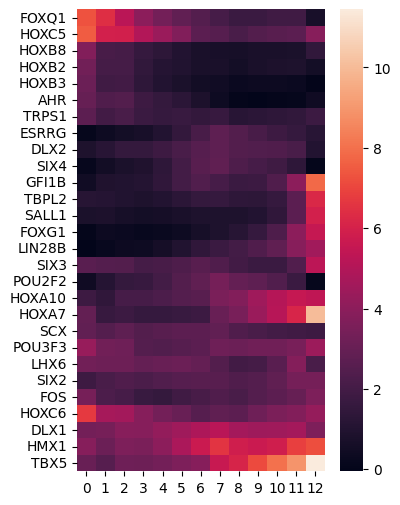

In [28]:
genes = [
'FOXQ1',
'HOXC5',
'HOXB8',
'HOXB2', 
'HOXB3', 
'AHR',   
'TRPS1', 
'ESRRG', 
'DLX2',  
'SIX4',  
'GFI1B', 
'TBPL2', 
'SALL1',  
'FOXG1', 
'LIN28B',
'SIX3',
'POU2F2',
'HOXA10',
'HOXA7',   
'SCX',   
'POU3F3',
'LHX6',  
'SIX2',  
'FOS',   
'HOXC6', 
'DLX1',
'HMX1',  
'TBX5'  
]
plt.subplots(1,1,figsize=(4,6))
c = sb.heatmap(np.log1p(mat.loc[genes]) ) 
#for g in genes:
#    print(g, aligner.results_map[g].alignment_str)
plt.savefig('heatmap_distant_gradient.pdf',bbox_inches='tight')

PATHWAY =======  gradient
mean matched percentage:  37.11 %
mean matched percentage wrt ref:  48.08 %
mean matched percentage wrt query:  44.23 %
Average Alignment:  IIIDIDIDIDIIIIDDMDMMDDD
Z-normalised Interpolated mean trends


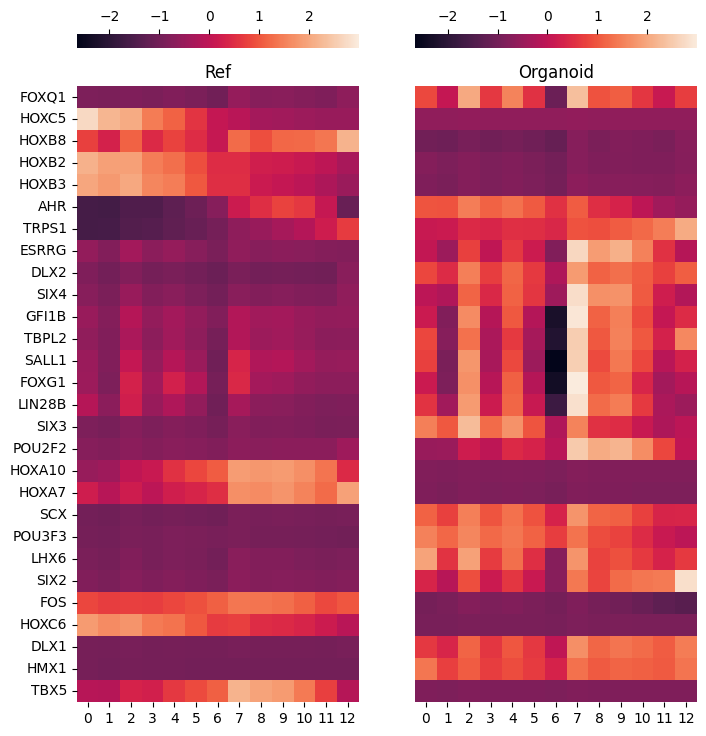

In [33]:
# Let's pick the pathways of interest from the above list and check their alignment statistics
from gsea_api.molecular_signatures_db import MolecularSignaturesDatabase
from adjustText import adjust_text
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import zscore

def visualize_gene_alignment(al_obj, vs):
    
    vega_20 = [
            '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728',
            '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2',
            '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
        ]

    fig = plt.figure(figsize=(4,3))
    heights = [1, 3, 1] 
    gs = plt.GridSpec(3, 1, height_ratios=heights)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0],sharex=ax1)
    ax3 = fig.add_subplot(gs[2, 0],sharex=ax1)

    #plt.subplots(3,1, gridspec_kw={'height_ratios': [1,10]})
    plt.subplot(3,1,1)
    vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=vega_20, grid = False, legend=False, width=0.7, ax=ax1)
    vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=vega_20, grid = False, legend=False, width=0.7,ax=ax3)
    plt.subplot(3,1,2)
    for i in range(al_obj.matched_region_DE_info.shape[0]):
                S_timebin = int(al_obj.matched_region_DE_info.iloc[i]['ref_bin'])
                T_timebin = int(al_obj.matched_region_DE_info.iloc[i]['query_bin'])
                #print(S_timebin, T_timebin)
                x_vals = [al_obj.matched_region_DE_info.iloc[i]['query_pseudotime'],al_obj.matched_region_DE_info.iloc[i]['ref_pseudotime']]#       [al_obj.matched_region_DE_info.iloc[i]['ref_pseudotime'],al_obj.matched_region_DE_info.iloc[i]['query_pseudotime']] 
                x_vals = [T_timebin+1, S_timebin+1]
                y_vals = [0,1]
                plt.plot(x_vals, y_vals, marker='.', color='black', linewidth=0.5)
  #  ax2.set_xlim([0,14])

    def set_grid_off(ax):

        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.figure.tight_layout()
        ax.grid(False)

    set_grid_off(ax1); set_grid_off(ax2); set_grid_off(ax3); 
    ax1.set_ylabel('Reference')
    ax3.set_ylabel('Query')
    fig.text(0.5, -0.05, 'Pseudotime bins with cell type composition', ha='center')
    ax1.set_title('Alignment w.r.t cell type compositions')



def plot_alignment_path_on_given_matrix(mat, paths, cmap='viridis'):

        fig,ax = plt.subplots(1,1, figsize=(7,7))
        sb.heatmap(mat, square=True,  cmap='viridis', ax=ax, cbar=True,xticklabels=True, yticklabels=True)  
        for path in paths: 
            path_x = [p[0]+0.5 for p in path]
            path_y = [p[1]+0.5 for p in path]
            ax.plot(path_y, path_x, color='white', linewidth=6)
        plt.xlabel("Reference pseudotime",fontweight='bold')
        plt.ylabel("Organoid pseudotime",fontweight='bold')
        ax.xaxis.tick_top() # x axis on top
        ax.xaxis.set_label_position('top')        
        
def get_pathway_alignment_stat(aligner, pathway_name, cluster=False):
    
    print('PATHWAY ======= ',pathway_name)
    GENE_LIST = IGS.SETS[pathway_name]
    perct_A = []
    perct_S = []
    perct_T = []
    for gene in GENE_LIST:
        series_match_percent = aligner.results_map[gene].get_series_match_percentage()
        perct_A.append(series_match_percent[0])
        perct_S.append(series_match_percent[1])
        perct_T.append(series_match_percent[2])

    print('mean matched percentage: ', round(np.mean(perct_A),2),'%' )
    print('mean matched percentage wrt ref: ',round(np.mean(perct_S),2),'%'  )
    print('mean matched percentage wrt query: ', round(np.mean(perct_T),2),'%' )
   # plt.subplots(1,1,figsize=(2,2))
    average_alignment, alignment_path =  ClusterUtils.get_cluster_average_alignments(aligner, GENE_LIST)
    mat = ClusterUtils.get_pairwise_match_count_mat(aligner,GENE_LIST )
    print('Average Alignment: ', average_alignment)
    #plot_alignment_path_on_given_matrix(paths = [alignment_path], mat=mat)


  #  plt.xlabel('Ref pseudotime')
  #  plt.ylabel('Organoid pseudotime')
   # plt.savefig('Fibro_ref_organoid_'+pathway_name+'_overall_alignment.png')
    plot_mean_trend_heatmaps(aligner, pathway_name,cluster=cluster) 

def plot_DE_genes(pathway_name):
    PATHWAY_SET = IGS.SETS[pathway]
    ax=sb.scatterplot(x['l2fc'],x['sim']*100,s=50, legend=False, hue =x['sim'] ,palette=sb.diverging_palette(15, 133, s=50, as_cmap=True),edgecolor='k',linewidth=0.3)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.ylabel('Alignment Similarity %', fontsize=12, fontweight='bold')
    plt.xlabel('L2FC mean expression', fontsize = 12, fontweight='bold')
    plt.grid(False)
    plt.tight_layout()

    TEXTS = [] 
    for label, a, b in zip(x.index, x['l2fc'],x['sim']*100):
        if(label in PATHWAY_SET):# and b<=50):
            TEXTS.append(ax.text(a, b, label, color='white', fontsize=9, fontweight='bold',bbox=dict(boxstyle='round,pad=0.1', fc='black', alpha=0.75)))
    adjust_text(TEXTS, expand_points=(2, 2),arrowprops=dict(arrowstyle="->", color='black', lw=2))
    plt.title(pathway_name,fontweight='bold', fontsize=15)
    
    
def plot_heatmaps(mat_ref,mat_query,pathway_name, cluster=False):
    
    if(cluster):
        g=sb.clustermap(mat_ref, figsize=(0.4,0.4), col_cluster=False) 
        gene_order = g.dendrogram_row.reordered_ind
        df = pd.DataFrame(g.data2d) 
        df.index = IGS.SETS[pathway_name][gene_order]
    else:
        df=mat_ref
    
    plt.subplots(1,2,figsize=FIGSIZE) #8,14/7 ******************************************************
    max_val = np.max([np.max(mat_ref),np.max(mat_query)]) 
    min_val = np.min([np.min(mat_ref),np.min(mat_query)]) 
    plt.subplot(1,2,1)
    ax=sb.heatmap(df, vmax=max_val,vmin=min_val, cbar_kws = dict(use_gridspec=False,location="top")) 
    plt.title('Ref')
    ax.yaxis.set_label_position("left")
    for tick in ax.get_yticklabels():
        tick.set_rotation(360)
    plt.subplot(1,2,2)
    if(cluster):
        mat_query = mat_query.loc[IGS.SETS[pathway_name][gene_order]] 
    ax = sb.heatmap(mat_query,vmax=max_val,  vmin=min_val,cbar_kws = dict(use_gridspec=False,location="top"), yticklabels=False) 
    plt.title('Organoid')
    plt.savefig(pathway_name+'_heatmap.pdf', bbox_inches='tight')
    plt.show()
    
    
# smoothened/interpolated mean trends + Z normalisation 
def plot_mean_trend_heatmaps(aligner, pathway_name, cluster=False):
    S_mat = []
    T_mat = []
    S_zmat = []
    T_zmat = []

    for gene in IGS.SETS[pathway_name]:

        fS = pd.DataFrame([aligner.results_map[gene].S.mean_trend, np.repeat('Ref', len(aligner.results_map[gene].S.mean_trend))]).transpose()
        fT = pd.DataFrame([aligner.results_map[gene].T.mean_trend, np.repeat('Organoid', len(aligner.results_map[gene].T.mean_trend))]).transpose()
        f = pd.concat([fS,fT])
        f[0] = np.asarray(f[0], dtype=np.float64)
        from scipy.stats import zscore
        f['z_normalised'] = zscore(f[0])
        S_mat.append(np.asarray(f[f[1]=='Ref'][0]))
        T_mat.append(np.asarray(f[f[1]=='Organoid'][0]))    
        S_zmat.append(np.asarray(f[f[1]=='Ref']['z_normalised']))
        T_zmat.append(np.asarray(f[f[1]=='Organoid']['z_normalised']))  
    S_mat = pd.DataFrame(S_mat)
    T_mat = pd.DataFrame(T_mat)
    S_zmat = pd.DataFrame(S_zmat)
    T_zmat = pd.DataFrame(T_zmat)
    
    S_mat.index = IGS.SETS[pathway_name]
    T_mat.index = IGS.SETS[pathway_name]
    S_zmat.index = IGS.SETS[pathway_name]
    T_zmat.index = IGS.SETS[pathway_name]
    
   # print('Interpolated mean trends')
   # plot_heatmaps(S_mat, T_mat, pathway_name, cluster=cluster)
    print('Z-normalised Interpolated mean trends')
    plot_heatmaps(S_zmat, T_zmat, pathway_name,cluster=cluster)
    
    
class InterestingGeneSets:
    
    def __init__(self):        
        self.SETS = {}
        self.dbs = {}
        self.msigdb = MolecularSignaturesDatabase('../MSIGDB/msigdbv2023.1', version='2023.1.Hs')
        #self.msigdb = MolecularSignaturesDatabase('../MSIGDB/msigdb7.5.1', version='7.5.1')
        self.dbs['kegg'] = self.msigdb.load('c2.cp.kegg', 'symbols')
        self.dbs['hallmark'] = self.msigdb.load('h.all', 'symbols')
     #   self.dbs['gobp'] = self.msigdb.load('c5.go.bp', 'symbols')
     #   self.dbs['gocc'] = self.msigdb.load('c5.go.cc', 'symbols')
     #   self.dbs['reac'] = self.msigdb.load('c2.cp.reactome', 'symbols')
        
    def add_new_set_from_msigdb(self, db_name, dbsetname, avail_genes, usersetname):
        self.SETS[usersetname] = np.intersect1d(list(self.dbs[db_name].gene_sets_by_name[dbsetname].genes), avail_genes)

    def add_new_set(self, geneset, usersetname, avail_genes):
        geneset = np.asarray(geneset)
        print(geneset)
        self.SETS[usersetname] = geneset[np.where([g in avail_genes for g in geneset])]

IGS = InterestingGeneSets() 
IGS.add_new_set( genes , 'gradient', genes)
FIGSIZE= (3,9)
get_pathway_alignment_stat(aligner, 'gradient', cluster=False)

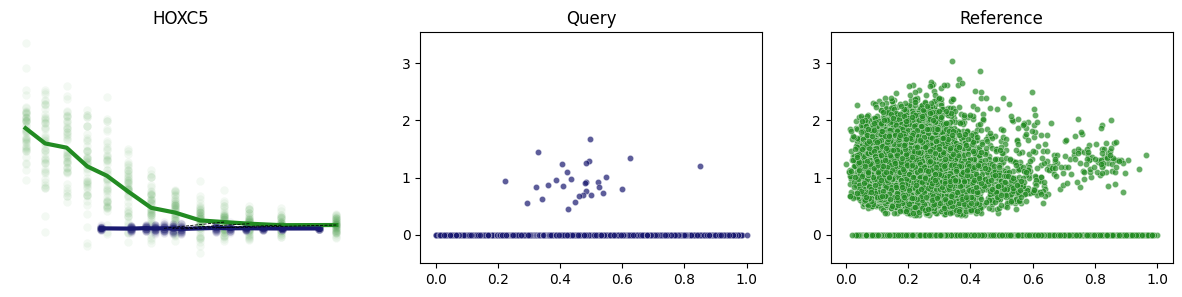

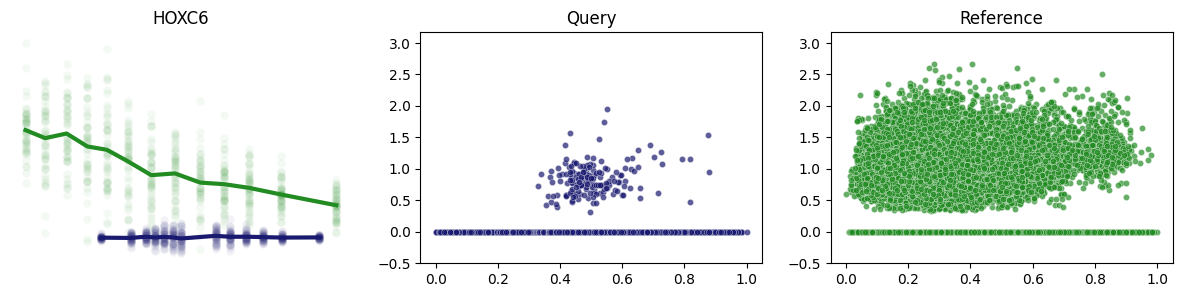

In [75]:
plotTimeSeries(aligner.results_map['HOXC5'], aligner, plot_cells=True) 
plotTimeSeries(aligner.results_map['HOXC6'], aligner, plot_cells=True) 

In [ ]:
plotTimeSeries(aligner.results_map['HOXC5'], aligner, plot_cells=True) 
plt.savefig('figs/HOXC5.pdf')
plotTimeSeries(aligner.results_map['ESRRG'], aligner, plot_cells=True) 
plt.savefig('figs/ESRRG.pdf')
plotTimeSeries(aligner.results_map['GFI1B'], aligner, plot_cells=True) 
plt.savefig('figs/GFI1B.pdf')
plotTimeSeries(aligner.results_map['HOXA7'], aligner, plot_cells=True) 
plt.savefig('figs/HOXA7.pdf')
plotTimeSeries(aligner.results_map['HOXC6'], aligner, plot_cells=True) 
plt.savefig('figs/HOXC6.pdf')